In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [39]:
#Data from vizier without treatment
raw_data = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\Visualizer\Datos_prueba.xlsx")

In [40]:
#Lines from the excel
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\Visualizer\Clean lines\Nave list NIR.xlsx")
raw_lambda['Nave list'] = (10**8)/raw_lambda['lambda']
raw_lambda = raw_lambda[raw_lambda['Nave list'].between(10000,23000,inclusive='right')]
raw_lambda = raw_lambda[raw_lambda['class']=='A'].reset_index(drop=True)

raw_lambda

,lambda,class,Nave list
0,9977.511,A,10022.539690
1,9975.027,A,10025.035521
2,9971.253,A,10028.829877
3,9964.517,A,10035.609353
4,9955.970,A,10044.224721
...,...,...,...
1849,4378.553,A,22838.595308
1850,4375.952,A,22852.170225
1851,4368.958,A,22888.752879
1852,4354.970,A,22962.270693


### Find the minimums and the closer line of the Fe I line


In [41]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda
    closer_data = closer_data[closer_data['abs'] <= 0.01].reset_index(drop=True)

    return closer_data.drop(['abs'],axis=1)

#Closer lines
closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,10022.532502,0.946571,10022.539690
1,10025.030255,0.957562,10025.035521
2,10028.834148,0.965678,10028.829877
3,10035.604601,0.942222,10035.609353
4,10067.811226,0.611177,10067.804651
...,...,...,...
65,10899.295600,0.776368,10899.287099
66,10916.022095,0.947302,10916.025960
67,10943.243347,0.847738,10943.236992
68,10979.670023,0.891460,10979.669824


In [42]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points


local_points = width_minimums(closer_lines,raw_data,0.05)

local_points

[         Wave (cm)     nFlux     rFlux        Wave A
 11911  9977.567120  0.962754  0.130610  10022.483317
 11912  9977.565236  0.961922  0.130497  10022.485209
 11913  9977.563353  0.961309  0.130414  10022.487100
 11914  9977.561470  0.960482  0.130302  10022.488992
 11915  9977.559587  0.959273  0.130138  10022.490884
 11916  9977.557703  0.958237  0.129997  10022.492776
 11917  9977.555820  0.957595  0.129910  10022.494667
 11918  9977.553937  0.957331  0.129874  10022.496559
 11919  9977.552054  0.956946  0.129822  10022.498451
 11920  9977.550170  0.956403  0.129749  10022.500343
 11921  9977.548287  0.955934  0.129685  10022.502234
 11922  9977.546404  0.954887  0.129543  10022.504126
 11923  9977.544521  0.953220  0.129317  10022.506018
 11924  9977.542637  0.952399  0.129206  10022.507910
 11925  9977.540754  0.952487  0.129217  10022.509801
 11926  9977.538871  0.952183  0.129176  10022.511693
 11927  9977.536987  0.951625  0.129101  10022.513585
 11928  9977.535104  0.95127

### Filter for the lines using the second derivate

In [43]:
def Fit_derivates(local_points,closer_lines):
    values = []
    fit = []
    local = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of lines 

        #Internal rise, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second

        flux_fit = poly.polyval(wave_scaled,param) #Evaluate the fit

        #First condition: The parameter of the order two polynomium need to be positive.
        #Second condition (for eliminate lineal terms): The distance between the initial and the final point need to be less than the half of depth
        #In other words, the final point need to be higher than the half of the distance between extreme points
  
        if d2_param[0]>0 and (data_flux.iloc[-1])>=(np.abs(data_flux.iloc[0]-data_flux.iloc[-1])/2):
    
            values.append(pd.DataFrame([[closer_lines['Fe line'].iloc[i],closer_lines['min_wave'].iloc[i],closer_lines['min_flux'].iloc[i]]])) 
            fit.append(flux_fit)
            local.append(local_points[i])

    Values = pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Line Fe I",'min_wave','min_flux']

    return Values,fit,local

Values,fit,local = Fit_derivates(local_points,closer_lines)

Values

,Line Fe I,min_wave,min_flux
0,10022.539690,10022.532502,0.946571
1,10025.035521,10025.030255,0.957562
2,10028.829877,10028.834148,0.965678
3,10035.609353,10035.604601,0.942222
4,10067.804651,10067.811226,0.611177
...,...,...,...
63,10887.246342,10887.252531,0.799046
64,10899.287099,10899.295600,0.776368
65,10916.025960,10916.022095,0.947302
66,10979.669824,10979.670023,0.891460


In [10]:
# Values.to_excel('valores_NIR_prueba.xlsx',index=False)

## Visualizer for the Fe I lines one by one

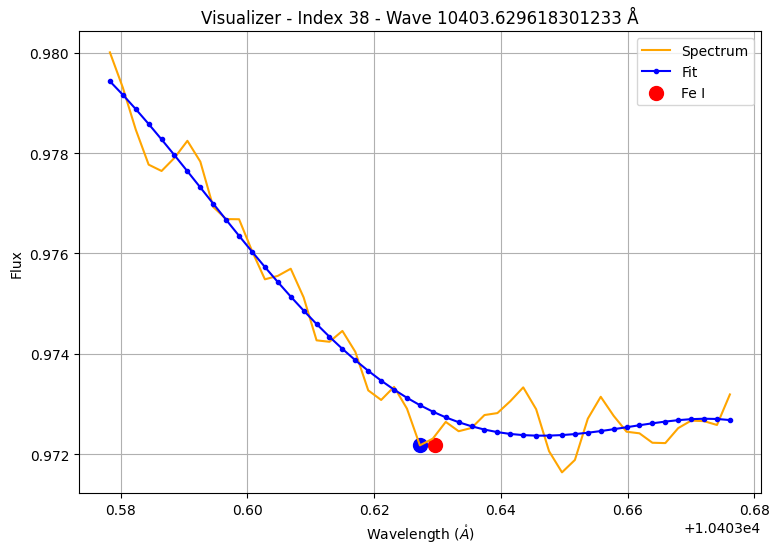

In [ ]:
# import tkinter as tk
# from tkinter import ttk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
# import numpy as np

# class OutlierViewer:
#     def __init__(self, root, local_points, values,fit):
#         self.root = root
#         self.root.title("Visualizer of Fe I lines identification")
#         self.local_points = local_points
#         self.values = values
#         self.fit = fit
#         self.index = values.index.values
#         self.current_index = 0
       
#         self.setup_ui()
#         self.update_plot()
    
#     def setup_ui(self):
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
        
#         control_frame = ttk.Frame(main_frame)
#         control_frame.pack(fill=tk.X, pady=10)
        
#         ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
#         self.slider = ttk.Scale(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             orient=tk.HORIZONTAL,
#             command=self.on_slider_move
#         )
#         self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
#         self.spinbox = ttk.Spinbox(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             width=5,
#             command=self.on_spinbox_change
#         )
#         self.spinbox.pack(side=tk.LEFT, padx=5)
#         self.spinbox.bind("<Return>", self.on_spinbox_change)
        
#         nav_frame = ttk.Frame(control_frame)
#         nav_frame.pack(side=tk.LEFT, padx=10)
        
#         ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
#         ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
#         graph_frame = ttk.Frame(main_frame)
#         graph_frame.pack(fill=tk.BOTH, expand=True)
       
#         self.fig, self.ax = plt.subplots(figsize=(10, 6))
#         self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
#         self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
#         self.toolbar.update()
#         self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
    
#     def on_slider_move(self, event=None):
#         self.current_index = int(float(self.slider.get()))
#         self.spinbox.delete(0, tk.END)
#         self.spinbox.insert(0, str(self.current_index))
#         self.update_plot()
    
#     def on_spinbox_change(self, event=None):
#         try:
#             new_index = int(self.spinbox.get())
#             if 0 <= new_index < len(self.index):
#                 self.current_index = new_index
#                 self.slider.set(self.current_index)
#                 self.update_plot()
#         except ValueError:
#             pass
    
#     def prev_plot(self):
#         if self.current_index > 0:
#             self.current_index -= 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def next_plot(self):
#         if self.current_index < len(self.index)-1:
#             self.current_index += 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     #Graficas
#     def update_plot(self):
#         j = self.current_index
#         self.ax.clear()
        
#         # Gráfica principal
#         self.ax.plot(
#             self.local_points[j]['Wave A'],
#             self.local_points[j]['nFlux'],
#             color='orange',
#             label='Spectrum'
#         )
        
#         #Closer lines
#         self.ax.plot(
#             self.local_points[j]['Wave A'],
#             self.fit[j],
#             color='blue',
#             label='Fit',
#             marker='.',
#         )
        
#         #Fe I line
#         self.ax.scatter(
#             self.values["Line Fe I"][j],
#             self.values['min_flux'][j],
#             color='red',
#             label='Fe I',
#             s=100
#         )

#         #Fe I line
#         self.ax.scatter(
#             self.values['min_wave'][j],
#             self.values["min_flux"][j],
#             color='blue',
#             s=100
#         )
        
#         #Vainitas del gráfico
#         self.ax.set_title(f'Visualizer - Index {self.index[j]} - Wave {self.values["Line Fe I"][j]} Å')
#         self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
#         self.ax.set_ylabel('Flux')
#         self.ax.legend()
#         self.ax.grid(True)
        
#         self.canvas.draw()


# if __name__ == "__main__":
#     root = tk.Tk()
#     root.geometry("900x700")
    
    
#     app = OutlierViewer(root, local, Values,fit)

#     root.mainloop()

## Visualizer for the check with the derivates

In [45]:
#Lines from the excel file
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Infrared range\Data\new_values_fe.xlsx")

raw_lambda

,Nave list
0,10035.6094
1,10067.8047
2,10084.1584
3,10087.8409
4,10092.5415
...,...
186,17688.7397
187,17775.9796
188,20722.6098
189,21254.7576


### Find the minimums and the closer line of the Fe I line


In [46]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,10035.604601,0.942222,10035.6094
1,10067.811226,0.611177,10067.8047
2,10084.158793,0.956740,10084.1584
3,10087.835211,0.968803,10087.8409
4,10092.540490,0.956926,10092.5415
...,...,...,...
186,10999.947482,0.939151,17688.7397
187,10999.947482,0.939151,17775.9796
188,10999.947482,0.939151,20722.6098
189,10999.947482,0.939151,21254.7576


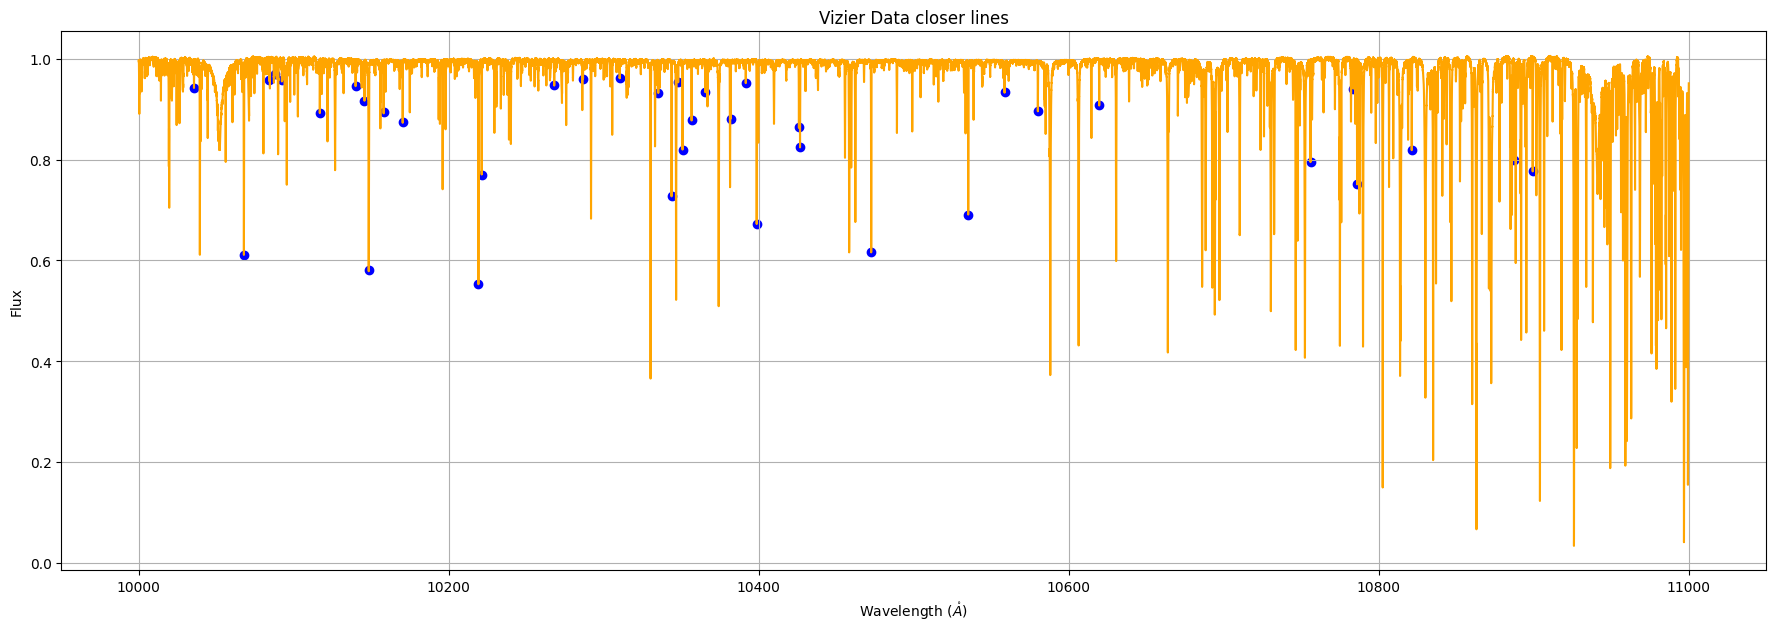

In [47]:
#Plot the identified lines
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)
closer_lines_10000_11000 = closer_lines[closer_lines['Fe line'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)

fig2, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(data_10000_11000['Wave A'],data_10000_11000['nFlux'], color='orange')
ax.scatter(closer_lines_10000_11000['min_wave'],closer_lines_10000_11000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [48]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points


local_points = width_minimums(closer_lines,raw_data,0.05)


### Derivates and fit

In [49]:
def Fit_derivates(local_points,lamda_list):
    values = []
    fit = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed. Re-scalated the coefficients
            d2 = (poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2))*(lamda_obs[0]**2) #Core curvature
            d3 = -(Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) ))*(const.c/lamda_obs[0]) #Bisector slope

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, second derivate, third derivate, convective blueshift
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2,d3,blueshift]])) 

            #Just in case of the visualizer take the fit values
            fit.append(flux_fit)

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Core curvature","Bisector slope","Blueshift"]

    return Values,fit

Values,fit = Fit_derivates(local_points,closer_lines['Fe line'])

Values

,Emitted wavelength,Observed wavelength,Flux,Velocity,Core curvature,Bisector slope,Blueshift
0,10035.6094,10035.6164,0.942566,-424,1.092415e+09,-1.544647e-08,209.110092
1,10067.8047,10067.8169,0.611079,-270,5.206249e+09,1.802525e-09,363.283565
2,10084.1584,10084.1685,0.956635,-333,1.039917e+09,-9.262597e-09,300.263414
3,10087.8409,10087.8493,0.967970,-383,6.806769e+08,-2.270661e-08,249.632867
4,10092.5415,10092.5375,0.957501,-752,5.799208e+08,2.077866e-08,-118.817429
5,10116.7892,10116.7970,0.892116,-402,2.487723e+09,-5.983817e-09,231.138667
6,10139.8807,10139.8825,0.945588,-580,1.164348e+09,-1.576064e-08,53.218222
7,10145.6242,10145.6287,0.916580,-500,1.427904e+09,2.138957e-09,132.970238
8,10148.3444,10148.3569,0.578729,-264,4.861451e+09,2.678436e-09,369.262766
9,10157.9490,10157.9565,0.892290,-412,2.369788e+09,-4.266898e-09,221.348171


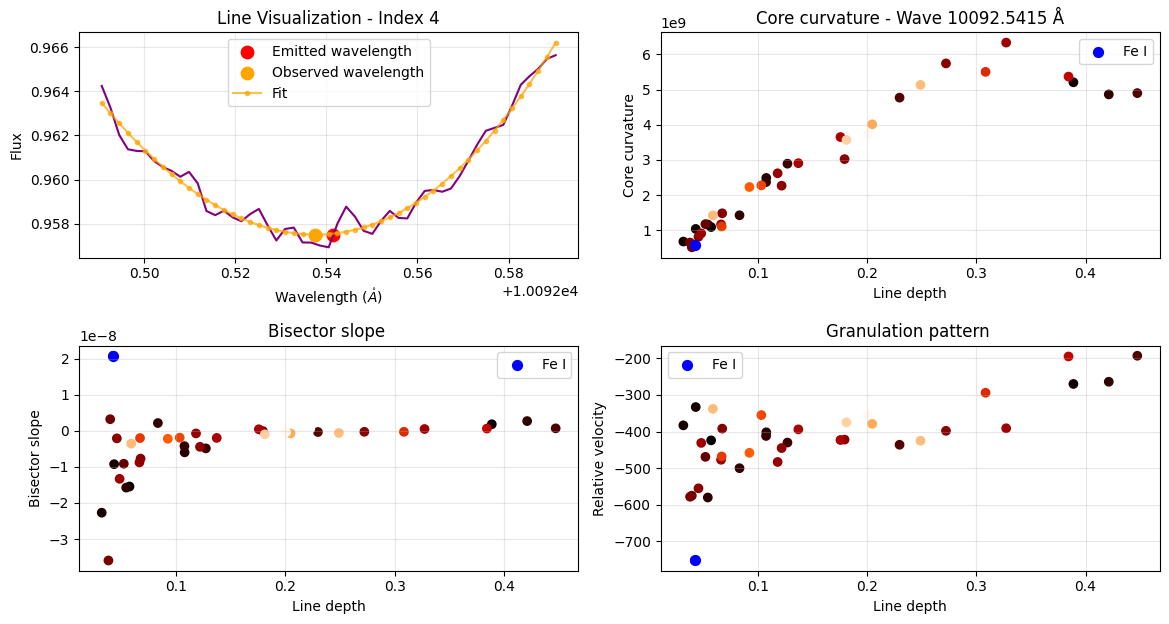

In [ ]:
# import tkinter as tk
# from tkinter import ttk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
# import numpy as np

# class OutlierViewer:
#     def __init__(self, root, local_points, values, fit):
#         self.root = root
#         self.root.title("Visualizer of Fe I lines identification")
#         self.local_points = local_points
#         self.values = values
#         self.fit = fit
#         self.index = values.index.values
#         self.current_index = 0
       
#         self.setup_ui()
#         self.update_plot()
    
#     def setup_ui(self):
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
        
#         control_frame = ttk.Frame(main_frame)
#         control_frame.pack(fill=tk.X, pady=10)
        
#         ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
#         self.slider = ttk.Scale(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             orient=tk.HORIZONTAL,
#             command=self.on_slider_move
#         )
#         self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
#         self.spinbox = ttk.Spinbox(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             width=5,
#             command=self.on_spinbox_change
#         )
#         self.spinbox.pack(side=tk.LEFT, padx=5)
#         self.spinbox.bind("<Return>", self.on_spinbox_change)
        
#         nav_frame = ttk.Frame(control_frame)
#         nav_frame.pack(side=tk.LEFT, padx=10)
        
#         ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
#         ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
#         graph_frame = ttk.Frame(main_frame)
#         graph_frame.pack(fill=tk.BOTH, expand=True)
       
#         # Crear figura con dos subplots
#         self.fig, self.axs = plt.subplots(2, 2, figsize=(20, 14))
#         self.ax1, self.ax2,self.ax3, self.ax4 = self.axs.flat
#         self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
#         self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
#         self.toolbar.update()
#         self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
    
#     def on_slider_move(self, event=None):
#         self.current_index = int(float(self.slider.get()))
#         self.spinbox.delete(0, tk.END)
#         self.spinbox.insert(0, str(self.current_index))
#         self.update_plot()
    
#     def on_spinbox_change(self, event=None):
#         try:
#             new_index = int(self.spinbox.get())
#             if 0 <= new_index < len(self.index):
#                 self.current_index = new_index
#                 self.slider.set(self.current_index)
#                 self.update_plot()
#         except ValueError:
#             pass
    
#     def prev_plot(self):
#         if self.current_index > 0:
#             self.current_index -= 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def next_plot(self):
#         if self.current_index < len(self.index)-1:
#             self.current_index += 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def update_plot(self):
#         j = self.current_index
        
#         self.ax1.clear()
#         self.ax2.clear()
#         self.ax3.clear()
#         self.ax4.clear()
        
#         #Plot 1
#         # Fe I line
#         self.ax1.plot(self.local_points[j]['Wave A'],
#                      self.local_points[j]['nFlux'],
#                      c='purple')

#         self.ax1.scatter(
#             self.values['Emitted wavelength'].iloc[j],
#             self.values["Flux"].iloc[j],
#             color='red',
#             s=80,
#             label='Emitted wavelength'
#         )

#         self.ax1.scatter(
#             self.values['Observed wavelength'].iloc[j],
#             self.values["Flux"].iloc[j],
#             color='orange',
#             s=80,
#             label='Observed wavelength'
#         )

#         # Fit
#         self.ax1.plot(self.local_points[j]['Wave A'],
#                      self.fit[j],
#                      c='orange',
#                      marker='.',
#                      label='Fit',
#                      alpha=0.7)
        
#         self.ax1.set_title(f'Line Visualization - Index {self.index[j]}')
#         self.ax1.set_xlabel(r'Wavelength $(\mathring{A})$')
#         self.ax1.set_ylabel('Flux')
#         self.ax1.grid(True, alpha=0.3)
#         self.ax1.legend()
        
#          # Plot 2
#         self.ax2.scatter(1-self.values['Flux'],
#                         self.values['Core curvature'],
#                         c=self.values["Observed wavelength"],
#                         cmap='gist_heat',lw=1)
        
#         #Fe I line
#         self.ax2.scatter(
#             1-self.values['Flux'].iloc[j],
#             self.values['Core curvature'].iloc[j],
#             color='blue',
#             label='Fe I',
#             s=50
#         )
        
        
#         self.ax2.set_title(f'Core curvature - Wave {self.values["Emitted wavelength"].iloc[j]} Å')
#         self.ax2.set_xlabel(r'Line depth')
#         self.ax2.set_ylabel('Core curvature')
#         self.ax2.grid(True, alpha=0.3)
#         self.ax2.legend()
        
#         # Plot 3
#         self.ax3.scatter(1-self.values['Flux'],
#                         self.values['Bisector slope'],
#                         c=self.values["Observed wavelength"],
#                         cmap='gist_heat',lw=1)
        
#         #Fe I line
#         self.ax3.scatter(
#             1-self.values['Flux'].iloc[j],
#             self.values['Bisector slope'].iloc[j],
#             color='blue',
#             label='Fe I',
#             s=50
#         )
        
        
#         self.ax3.set_title(f'Bisector slope ')
#         self.ax3.set_xlabel(r'Line depth')
#         self.ax3.set_ylabel('Bisector slope')
#         self.ax3.grid(True, alpha=0.3)
#         self.ax3.legend()

#         # Plot 4
#         self.ax4.scatter(1-self.values['Flux'],
#                         self.values['Velocity'],
#                         c=self.values["Observed wavelength"],
#                         cmap='gist_heat',lw=1)
#         # 
#         #Fe I line
#         self.ax4.scatter(
#             1-self.values['Flux'].iloc[j],
#             self.values['Velocity'].iloc[j],
#             color='blue',
#             label='Fe I',
#             s=50
#         )
        
        
#         self.ax4.set_title(f'Granulation pattern ')
#         self.ax4.set_xlabel(r'Line depth')
#         self.ax4.set_ylabel('Relative velocity')
#         self.ax4.grid(True, alpha=0.3)
#         self.ax4.legend()

#         self.fig.tight_layout()
        
#         self.canvas.draw()


# if __name__ == "__main__":
#     root = tk.Tk()
#     root.geometry("1200x700") 
    
#     app = OutlierViewer(root, local_points, Values, fit)
#     root.mainloop()

## Lines to drop in the excel

In [21]:
# index_to_drop = [0,1,2,14,15,22,23,29,37,38,47,48,49,50,51,53,54,55,
#                  58,60,64,65,69,70,71,72,73,74,75,80,83,84,85,89,90,95,
#                  97,98,101,102,104,106,116,117,118,119,120,121,129,134,
#                  138,142,145,146,148,150,157,163,168,169,176,178,180,183,
#                  188,195,203,205,209,211,215,219,222,223,227,232,236,237,
#                  242,243,244,245,247,248,249,252,259,261,269,273,276,277,
#                  278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,
#                  295,296,298,301,302,303,304,305,306,307,308,309,310,311,312,313]

# Values = Values.drop(index_to_drop).reset_index(drop=True)

# Values

In [ ]:

#Convert to excel
# Values.to_excel('valores vacio Nave NIR_ultima.xlsx', index=False)

In [ ]:
# #Lines from the excel
# raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Visualizer\Clean lines\Nave list NIR.xlsx")
# raw_lambda['Nave list'] = (10**8)/raw_lambda['lambda']
# raw_lambda = raw_lambda[raw_lambda['Nave list'].between(10000,23000,inclusive='right')]
# raw_lambda = raw_lambda[raw_lambda['class']=='A'].reset_index(drop=True)

# raw_lambda

,lambda,class,Nave list
0,9977.511,A,10022.539690
1,9975.027,A,10025.035521
2,9971.253,A,10028.829877
3,9964.517,A,10035.609353
4,9955.970,A,10044.224721
...,...,...,...
1849,4378.553,A,22838.595308
1850,4375.952,A,22852.170225
1851,4368.958,A,22888.752879
1852,4354.970,A,22962.270693


In [ ]:
# round(raw_lambda[raw_lambda['Nave list'].between(17165,17180)],4)

,lambda,class,Nave list
1310,5825.538,A,17165.7965
1311,5823.811,A,17170.8869
